# B(M1) analysis

Collect proton/neutron M1 matrix elements from runs using random samples of USDB

$ B(M1) = \left[ g_s^p M_s^p + g_l^p M_l^p +  g_s^n M_s^n + g_l^n M_l^n  \right] ^2$ 

Free nucleon values:

$g_s^p = 5.5857$

$g_s^n = -3.8263 $

$g_l^p = 1.0 $

$g_l^n = 0.0 $ 



In [1]:
import numpy as np

import os
from glob import glob
from tqdm import tqdm

def optimal_n_bins(y,max_bins=100):
    from scipy.stats import iqr
    n_bins = int((max(y) - min(y))/(2*iqr(y)*len(y)**(-1/3)))
    return min(n_bins,max_bins)

import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'serif',
        'serif'  : ['Palatino'],
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import pickle as pkl
import sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [2]:
from scipy.special import factorial2

hbarc = 197300 #keV fm
hbar = 6.582E-19 #keV s
alpha = 1/137
mP = 938272 # kev/c^2
#muN = 3.152E-14 # MeV / T
muN2 =  alpha*hbarc**3*2*mP**-2 # nuclear magneton squared


def Thalf_width(E): #converts energy width (MeV) to Thalf in seconds
    return hbar * np.log(2)/(E/1000)

def Thalf_width_kev(E):
    if E==0.:
        return None
    return Thalf_width(E)

def times_so_far(ls):
    out = [0]*len(ls)
    for i in range(len(ls)):
        out[i] = ls[:i+1].count(ls[i])
    return out

def j_to_twoj(x):
    if '/2' in x:
        return int(x.strip('/2'))
    else:
        return 2*int(x.strip('()'))
    
def thalf_units_to_sec(units,value):
    m=0
    if units=='PS':
        m = 10**-12
    elif units=='NS':
        m = 10**-9
    elif units=='FS':
        m = 10**-15
    elif units=='US':
        m = 10**-6
    elif units=='AS':
        m = 10**-18
    elif units=='KEV':
        pass
    if m==0:
        return Thalf_width_kev(value)
    else:
        return m*value
    
def fLambda(l):
    return 8*np.pi*(l+1)/(l*(factorial2(2*l+1)**2))

def Bweisskopf(l,A):
    # Weisskopf estimate for El
    return (1/(4*np.pi)) * (3/(3+l))**2 * (1.2*A**(1/3))**(2*l)
    
def B_M1_Wu(B):
    return B / 1.79

In [5]:
csv_raw = 'IAEA_magn_mom_recomm.csv'
df_raw = pd.read_csv(csv_raw)

In [6]:
df_raw

,z,n.n+n.z,symbol,energy [keV],halflife,spin,magnetic dipole [nm],method,description,nsr,journal,indc
0,0,1,NN,0,10.2 m,1/2+,-1.9130427(5),R,Re-evaluated by N.J. Stone (2013StZZ) usually ...,2014Ol01,Chin. Phys. C38 090001 (2014),indc-nds-0794
1,1,1,H,0,stable,1/2+,+2.792847351(9),R,Re-evaluated by N.J. Stone (2013StZZ) usually ...,2014Ol01,Chin. Phys. C38 090001 (2014),indc-nds-0794
2,1,2,H,0,stable,1+,+0.857438231(5),R,Re-evaluated by N.J. Stone (2013StZZ) usually ...,2014Ol01,Chin. Phys. C38 090001 (2014),indc-nds-0794
3,1,3,H,0,12.33 y,1/2+,+2.978962460(14)),R,Re-evaluated by N.J. Stone (2013StZZ) usually ...,2014Ol01,Chin. Phys. C38 090001 (2014),indc-nds-0794
4,2,3,He,0,stable,1/2+,-2.12762531(3),R,Re-evaluated by N.J. Stone (2013StZZ) usually ...,2012Mo42,RMP 84 1527 (2012),indc-nds-0794
...,...,...,...,...,...,...,...,...,...,...,...,...
2150,96,247,Cm,0,1.56 x 107 y,9/2-,0.36(7),EPR,Electron Paramagnetic Resonance,1973Ab03,PL 44A 527 (73),indc-nds-0794
2151,97,249,Bk,0,330 d,7/2+,2.0(4),EPR,Electron Paramagnetic Resonance,1972Bo67,PL 42A 93 (72),indc-nds-0794
2152,99,253,Es,0,20.5 d,7/2+,+4.10(7),AB/D,Atomic Beam Magnetic Resonance (direct moment ...,1975Go05,PR A11 499 (75),indc-nds-0794
2153,99,254,Es,84,39.3 h,2+,2.90(7),AB,Atomic Beam Magnetic Resonance - Thermal Beam,1975Go05,PR A11 499 (75),indc-nds-0794


In [7]:
idx = df_usdb[(df_usdb['Mth_sp']==-999.0) | (df_usdb['Mth_lp']==-999.0) | (df_usdb['Mth_sn']==-999.0) | (df_usdb['Mth_ln']==-999.0)].index
df_usdb.loc[idx,'Include']=False

idx = df_usdb[(df_usdb['Mth_sp']==0.0) & (df_usdb['Mth_lp']==0.0) & (df_usdb['Mth_sn']==0.0) & (df_usdb['Mth_ln']==0.0)].index
df_usdb.loc[idx,'Include']=False

B_min = 0.01
n_max = 6
idx = df_usdb[(df_usdb['ni']>n_max) | (df_usdb['nf']>n_max)].index
df_usdb.loc[idx,'Include']=False

idx = df_usdb[(df_usdb['B_exp (W.u.)']<B_min)].index
df_usdb.loc[idx,'Include']=False

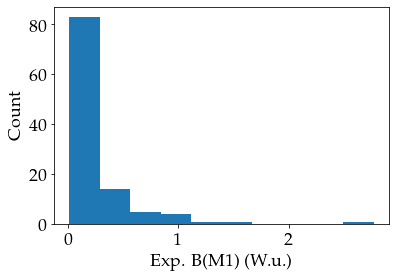

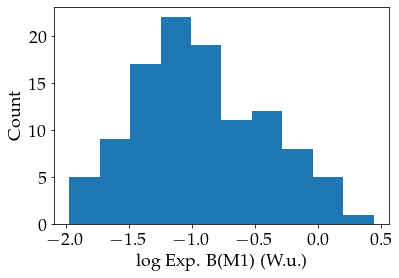

Out of 109 transitions, 103 are smaller than the Weisskopf estimate


In [8]:
y = df_usdb['B_exp (W.u.)']
plt.hist(y, bins=10, density=False)
plt.xlabel('Exp. B(M1) (W.u.)')
plt.ylabel('Count')
plt.show()

y = np.log10(df_usdb['B_exp (W.u.)'])
plt.hist(y, bins=10, density=False)
plt.xlabel('log Exp. B(M1) (W.u.)')
plt.ylabel('Count')
plt.show()
print(f'Out of {len(y)} transitions, {len(y[y<0])} are smaller than the Weisskopf estimate')

In [9]:
# df_input = df_input.rename(columns={'Unnamed: 0':'Index'})
df_usdb = df_usdb.rename(columns={'Unnamed: 0':'Index'})

In [10]:
# df_input = df_input[df_input['Include']==True]
df_usdb = df_usdb[df_usdb['Include']==True]

In [11]:
usdbmil = np.loadtxt('/p/lustre2/fox39/shmuq/usdb/shmuq_m1/usdbmil.vec',skiprows=1)
usdb = np.loadtxt('/p/lustre2/fox39/shmuq/usdb/shmuq_m1/usdb.vec',skiprows=1)

In [12]:
n_transitions = len(df_usdb)
n_params = 66
print('# transitions =', n_transitions)

# transitions = 88


In [13]:
df_usdb.keys()

Index(['Index', 'A', 'Element', 'Z', 'N', 'Energy (keV)', 'Energy Unc (keV)',
       'Ji', 'Thalf', 'E_gamma (keV)', 'E_gamma Unc (keV)', 'I_gamma',
       'I_gamma Unc', 'Mult', 'B_exp (W.u.)', 'B_exp Unc (W.u.)', 'twoJi',
       'Thalf Value', 'Thalf Units', 'Thalf Unc', 'Thalf (sec)',
       'Thalf Unc (sec)', 'B_exp (mu_N^2)', 'B_exp Unc (mu_N^2)', 'Nucleus',
       'Jf', 'twoJf', 'ni', 'nf', 'Include', 'Mth_sp', 'Mth_sn', 'Mth_lp',
       'Mth_ln'],
      dtype='object')

In [14]:
# plot error distribution with free nucleon couplings
B_exp = np.array(df_usdb['B_exp (W.u.)'])
B_exp_unc = np.array(df_usdb['B_exp Unc (W.u.)'])
M_sp = np.array(df_usdb['Mth_sp'])
M_lp = np.array(df_usdb['Mth_lp'])
M_sn = np.array(df_usdb['Mth_sn'])
M_ln = np.array(df_usdb['Mth_ln'])
g_sp_free = 5.5857
g_lp_free = 1.
g_sn_free = -3.8263
g_ln_free = 0.

def B_th(g_vec):
    g_sp, g_lp, g_sn, g_ln = g_vec
    B = ( g_sp * M_sp + g_lp * M_lp + g_sn * M_sn + g_ln * M_ln )**2
    return B

def chi2(g_vec,B_th_unc):
    # in W.u.
    R2 = (B_exp - B_M1_Wu(B_th(g_vec)))**2 / (B_exp_unc**2 + B_th_unc**2)
    chi2 = np.sum(R2)
    return chi2

n_params = 66
n_transitions = len(B_exp)
g_vec_free = [g_sp_free, g_lp_free, g_sn_free, g_ln_free]
chi2(g_vec_free,0.4)/(n_transitions - n_params)

0.9748832043600705

In [15]:

def objective(x):
    return (1 -  ( chi2(g_vec_free,x)/(n_transitions-n_params) ) )**2

from scipy.optimize import minimize_scalar
opt_result = minimize_scalar(objective,)
print(opt_result.x)

0.39391386877509754


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


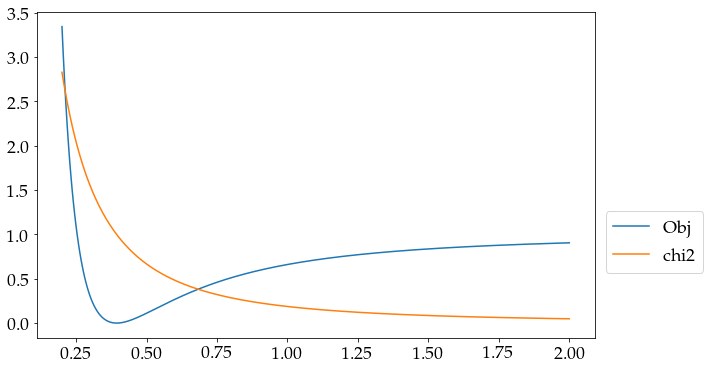

In [16]:
domain = np.linspace(0.2,2,400)
y = [objective(x) for x in domain]
y2 = [chi2(g_vec_free,x)/(n_transitions - n_params) for x in domain]

plt.figure(figsize=(10,6))
plt.plot(domain,y,label='Obj')
plt.plot(domain,y2,label='chi2')
plt.legend(loc = (1.02,0.2))
plt.show()

In [17]:
B_M1_th_unc = opt_result.x

In [18]:
from scipy.optimize import least_squares
opt = least_squares(chi2, x0=g_vec_free, args=[B_M1_th_unc])
g_vec_opt = opt.x

print(g_vec_opt)

[ 5.29598269  0.57335945 -2.68287497 -0.42862994]


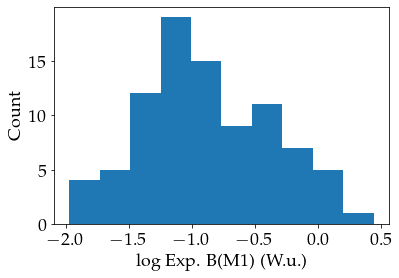

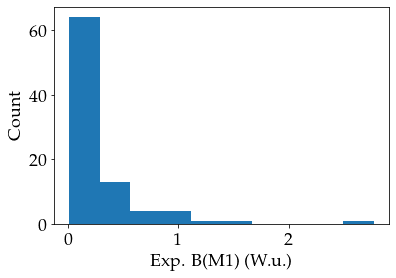

In [19]:
y = np.log10(B_exp)
plt.hist(y, bins=10, density=False)
plt.xlabel('log Exp. B(M1) (W.u.)')
plt.ylabel('Count')
plt.show()
plt.hist(B_exp, bins=10, density=False)
plt.xlabel('Exp. B(M1) (W.u.)')
plt.ylabel('Count')
plt.show()

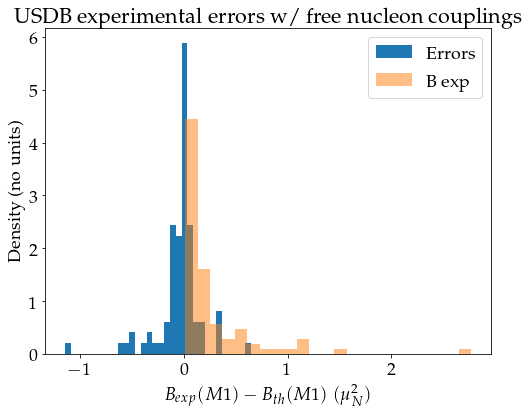

Average error with no model: 0.26921136363636367
Average error with our model: -0.03722062737598697
std of errors: 0.2185473116876484


In [20]:
y = B_exp - B_M1_Wu(B_th(g_vec_free))
plt.figure(figsize=(8,6))
plt.hist(y,bins=optimal_n_bins(y),density=True,label='Errors')
plt.hist(B_exp,bins=optimal_n_bins(B_exp),density=True,label='B exp',alpha=0.5)
plt.xlabel(r'$B_{exp}(M1) - B_{th}(M1)$    $(\mu_N^2)$')
plt.ylabel('Density (no units)')
plt.title('USDB experimental errors w/ free nucleon couplings')
plt.legend()
plt.show()

print(f'Average error with no model: {np.mean(B_exp)}')
print(f'Average error with our model: {np.mean(y)}')

print(f'std of errors: {np.std(y)}')

In [21]:
df_usdb.loc[:,'B_rel_err (W.u.)'] = (B_exp - B_M1_Wu(B_th(g_vec_free)))/B_exp

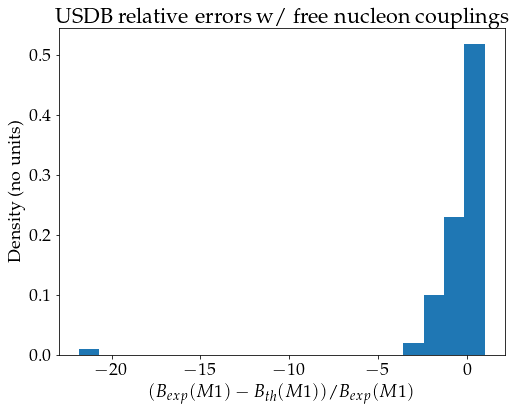

In [22]:
plt.figure(figsize=(8,6))
plt.hist(df_usdb['B_rel_err (W.u.)'],bins=20,density=True)
plt.xlabel(r'$( B_{exp}(M1) - B_{th}(M1) ) / B_{exp}(M1)$    ')
plt.ylabel('Density (no units)')
plt.title('USDB relative errors w/ free nucleon couplings')
plt.show()

In [23]:
B_rel_limit = 5
df_usdb.loc[np.abs(df_usdb['B_rel_err (W.u.)'])>B_rel_limit,'Include'] = True

In [ ]:
data_path = '/p/lustre2/fox39/shmuq/usdb/shmuq_m1/batch_results'
df_dict = {}
problem_cases = []
numbers_list = []
for batch_dir in tqdm(sorted(glob(os.path.join(data_path,'batch_job*')))):
#     print(batch_dir)
    for csv_path in sorted(glob(os.path.join(batch_dir,'sd_M1_usdb_rand?????.csv'))):
        csv_name = os.path.split(csv_path)[-1]
#         print(csv_name)
        int_vec_name = csv_name[6:].replace('.csv','.vec')
#         print(int_vec_name)
        mil_vec_name = int_vec_name.replace('usdb','usdbmil')
#         print(mil_vec_name)
        run_num_string = int_vec_name.split('rand')[-1][:-4]
        print(run_num_string)
        
        numbers_list.append(run_num_string)
        
        try:
            df_dict[run_num_string] = [pd.read_csv(os.path.join(batch_dir,csv_name)), 
                                   np.loadtxt(os.path.join(batch_dir,int_vec_name),skiprows=1), 
                                   np.loadtxt(os.path.join(batch_dir,mil_vec_name),skiprows=1)]
        except OSError:
            problem_cases.append(run_num_string)
            print('--------WARNING--------')
            print(f'PROBLEM AT {run_num_string}')

  0%|          | 0/1000 [00:00<?, ?it/s]

00001
00002
00003
00004
00005
00006
00007
00008
00009
00010


  0%|          | 1/1000 [00:04<1:22:02,  4.93s/it]

00011
00012
00013
00014
00015
00016
00017
00018
00019
00020


  0%|          | 2/1000 [00:09<1:20:18,  4.83s/it]

00021
00022
00023
00024
00025
00026
00027
00028
00029
00030


  0%|          | 3/1000 [00:14<1:16:38,  4.61s/it]

00031
00032
00033
00034
00035
00036
00037
00038
00039
00040


  0%|          | 4/1000 [00:17<1:11:01,  4.28s/it]

00041
00042
00043
00044
00045
00046
00047
00048
00049
00050


  0%|          | 5/1000 [00:29<1:55:53,  6.99s/it]

00051
00052
00053
00054
00055
00056
00057
00058
00059
00060


  1%|          | 6/1000 [01:10<5:07:19, 18.55s/it]

00061
00062
00063
00064
00065
00066
00067
00068


In [ ]:
with open('m1_results_10k_noF.pkl','wb') as fh:
    pkl.dump(df_dict,fh)

In [ ]:
for w in problem_cases:
    print(w )

In [ ]:
n_samples = len(numbers_list)
print(f'Total number of samples = {n_samples}')